In [59]:
import pandas as pd
import numpy as np
from sklearn import metrics
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Reading Dataset

In [14]:
# read in train and test
df_raw = pd.read_pickle('../data/raw/dataset.pkl')
df = pd.read_pickle('../data/training_sets/dataset_v001.pkl')
df_train = pd.read_pickle('../data/interim/train.pkl')
df_test = pd.read_pickle('../data/interim/test.pkl')

In [64]:
print('Length of the raw dataset: ' + str(len(df_raw)))
print('Length of the cleaned and balanced dataset: ' + str(len(df)))

Length of the raw dataset: 11987
Length of the cleaned and balanced dataset: 7194


In [17]:
fig = px.bar(x=df_raw.label.value_counts().index, y=df_raw.label.value_counts(), text = 100*df_raw.label.value_counts()/len(df_raw), template='plotly_dark')
fig.update_layout(title={'text': 'Label univariate distribution in the dataset'})
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside', textfont_size=14, marker_color='indianred')
fig.show()

* The raw dataset covers 11230 unique terms.
* In total we have 6 different labels which are `non_science`, `protein`, `reagent`, `cell`, `drug` and `antibiotic` encoded as `3`, `4`, `5`, `1`, `2` and `0` respectively.
* Datasets have no missing values but some wikipedia results contain no information about the term which can also be considered as missing data.
* Data is imbalanced.

## Loading champion models

In [4]:
sgd = pickle.load(open('../model/SGDModel.pkl', 'rb'))
mnb = pickle.load(open('../model/MultinomialNBModel.pkl', 'rb'))

In [5]:
X_train, X_test, y_train, y_test = df_train['text_clean'].values, df_test['text_clean'].values, df_train['label_encoded'].values, df_test['label_encoded'].values

# Model Evaluation

In [60]:
def plot_metrics(model, X_test, y_test):

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)

    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=2)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                               predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(fpr, tpr))
                   )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

Accuracy: 0.92
Auc: 0.99
Detail:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       356
           1       0.95      0.94      0.94       366
           2       0.89      0.93      0.91       330
           3       0.93      0.99      0.96       364
           4       0.88      0.91      0.90       364
           5       0.92      0.82      0.86       379

    accuracy                           0.92      2159
   macro avg       0.92      0.92      0.92      2159
weighted avg       0.92      0.92      0.92      2159



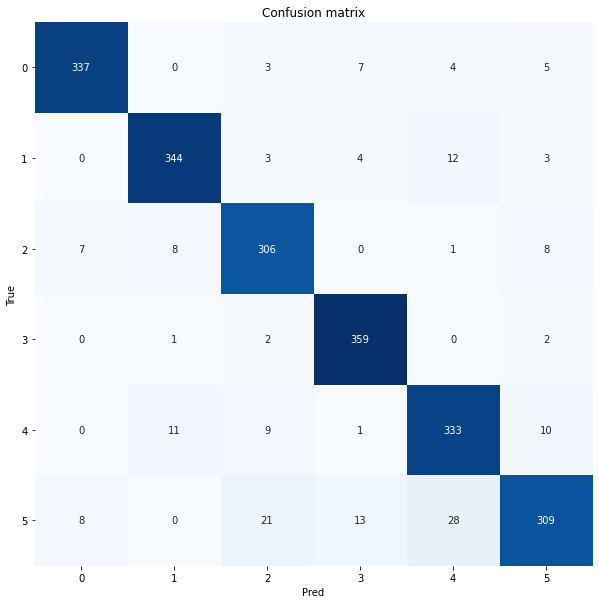

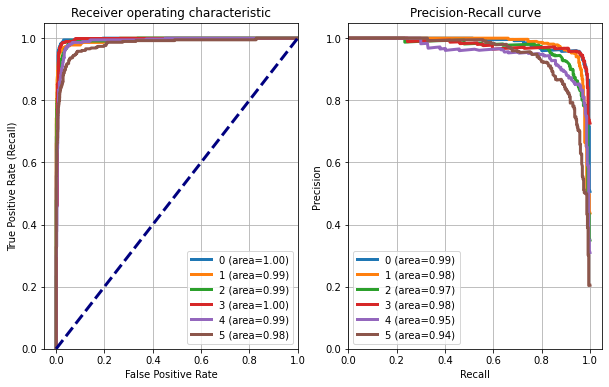

In [61]:
plot_metrics(sgd, X_test, y_test)

Accuracy: 0.85
Auc: 0.97
Detail:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       356
           1       0.93      0.92      0.92       366
           2       0.84      0.86      0.85       330
           3       0.84      0.96      0.90       364
           4       0.79      0.90      0.84       364
           5       0.81      0.64      0.71       379

    accuracy                           0.85      2159
   macro avg       0.85      0.85      0.85      2159
weighted avg       0.85      0.85      0.85      2159



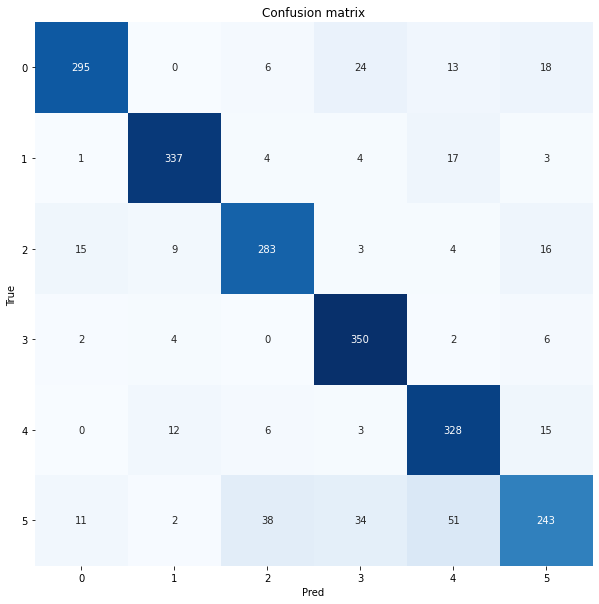

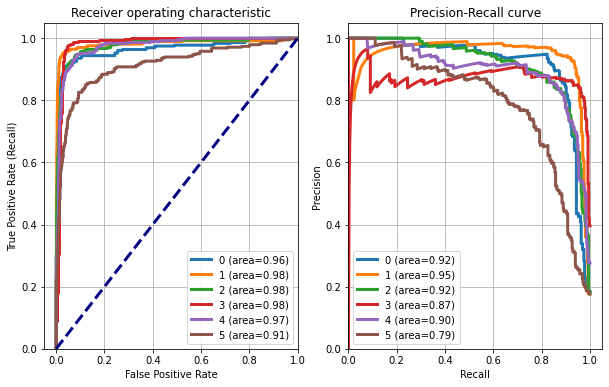

In [62]:
plot_metrics(mnb, X_test, y_test)

# Conclusion

By looking at the confusion matrices and ROC curves, we can say that SGD model outperformed the MultinomialNB model. Most of the misclassified observations has the label of `reagent` which is encoded as `5` and the second most misclassified label is `protein` which is encoded as `4`. Some insights from classification report of SGD model:

* Recall for `reagent` is 0.82 meaning 82% of the `reagent`labels predicted correctly. On the other hand, precision for `reagent` is better at 0.92.
* Recall for `non-science` is almost perfect at 0.99.
* Precision for  `protein` and `drug` is slightly higher than others. By looking at the confusion matrix, `reagent` is misclassified as `protein` or `drug` for more then 40 observations.